# 1. Does the implemented language model predict the next token based on all the past tokens up to the very first token in The Time Machine?

The prediction of the next token is influenced by a fixed-length context window, which is controled by the hyperparameter of prefix

# 2. Which hyperparameter controls the length of history used for prediction?

prefix

# 3. Show that one-hot encoding is equivalent to picking a different embedding for each object.

In [ ]:
import torch
import torch.nn.functional as F

# Create a tensor of indices representing the categories A, B, C, and D
indices = torch.tensor([0, 1, 2, 3])

# Create a one-hot encoded tensor from the indices
one_hot = F.one_hot(indices)

# Create an embedding matrix of size 4 x 3
embedding = torch.tensor([[0.2, -0.5, 0.7],
                          [-0.1, 0.3, -0.6],
                          [0.4, -0.2, 0.1],
                          [-0.3, 0.6, -0.4]])

result = torch.matmul(one_hot[2].float(), embedding)
# Print the result
print(result)

# 4. Adjust the hyperparameters (e.g., number of epochs, number of hidden units, number of time steps in a minibatch, and learning rate) to improve the perplexity. How low can you go while sticking with this simple architecture?

In [14]:
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
from torch.nn import functional as F
warnings.filterwarnings("ignore")

class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
        
    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens),
                              device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = torch.tanh(torch.matmul(X, self.W_xh) +
                             torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state
    
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)
        return l
        
    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

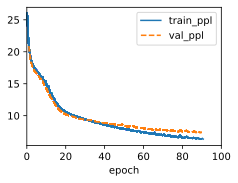

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)

# 5. Replace one-hot encoding with learnable embeddings. Does this lead to better performance?

# 6. Conduct an experiment to determine how well this language model trained on The Time Machine works on other books by H. G. Wells, e.g., The War of the Worlds.

# 7. Conduct another experiment to evaluate the perplexity of this model on books written by other authors.

# 8. Modify the prediction method so as to use sampling rather than picking the most likely next character.

## 8.1 What happens?

## 8.2 Bias the model towards more likely outputs, e.g., by sampling from $q(x_{t}|x_{t-1},\dots,x_1) \propto P(x_{t}|x_{t-1},\dots,x_1)^\alpha$ for $\alpha>1$.

# 9. Run the code in this section without clipping the gradient. What happens?

# 10. Replace the activation function used in this section with ReLU and repeat the experiments in this section. Do we still need gradient clipping? Why?